defaultdict(<class 'list'>, {20000.0: [14.395758061, 10.794398341, 10.729266083, 10.837266337, 10.559179035], 15000.0: [16.613098945, 16.977159631, 11.508962681, 15.010787749, 10.958720499], 10000.0: [12.230470622, 11.550575327, 11.280056839, 11.724253612, 12.334348583], 5000.0: [13.414762932, 13.66657297, 13.37174435, 12.898673401, 13.502907358], 1000.0: [25.953084336, 26.026381907, 25.267830402, 25.149868179, 26.370428001]})
defaultdict(<class 'list'>, {20000.0: [13.12239905, 12.887016895, 12.913666053, 13.081525369, 12.072239101], 15000.0: [12.159568678, 12.006740315, 11.755750928, 12.985721605, 12.909020013], 10000.0: [13.064703985, 13.544214387, 13.196721176, 13.183699517, 13.178532246], 5000.0: [14.098138724, 14.202581317, 14.746641092, 14.300214907, 14.467471073], 1000.0: [26.560373364, 27.128351769, 26.479685349, 26.354058487, 26.437369408]})


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure i

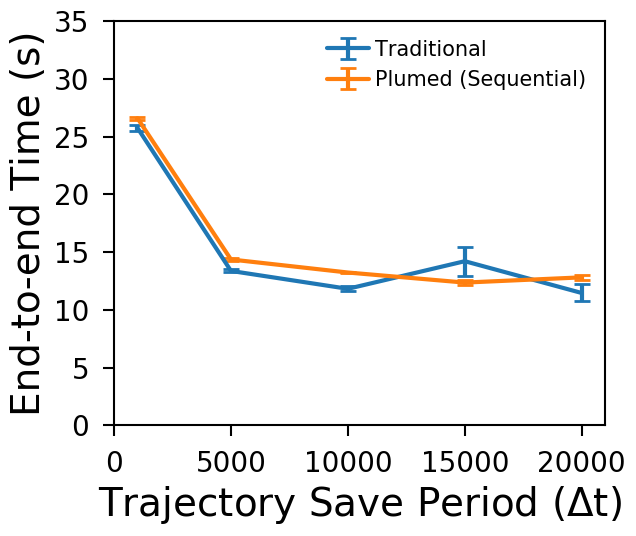

In [2]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

def timestamp_to_seconds(t):
    return sum(float(n) * m for n, m in zip(reversed(t), (1, 60, 3600)))

# This will return absolute paths
paths = {'sequential_using_mdtraj':'Traditional','sequential_in_transit_plumed_global_module':'Plumed (Sequential)'}
for path,legend in paths.items():
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        total_time=None
        dump_interval = None
        sim_times=[]
        with open(log_file) as fp:
            line = fp.readline()
            #print(line)
            while line:
                if 'DUMP_INTERVAL' in line:
                    #print(line)
                    values = line.split(':')
                    if float(values[1]) >500:
                        dump_interval = float(values[1])
                if 'Total wall time' in line:
                    values = line.split(':')
                    sim_time = float(timestamp_to_seconds(values[1:]))
                    sim_times.append(sim_time)
                if 'ETE_TIME' in line:
                    #print(line)
                    values = line.split(':')
                    total_time = float(values[1])
                    break
                line = fp.readline()
            if total_time is not None and dump_interval is not None:
                total_times[dump_interval].append(total_time)
        if len(sim_times)>0 and dump_interval is not None:
            #print(log_file)
            sim_time_dict[dump_interval].append(sim_times[-1])
        else:
            #print('Could not find sim time in ',log_file)
            continue
    print(total_times)
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    dump_intervals = total_times.keys()
    plt.errorbar(dump_intervals,mean_tts,std_tts, 
                 #fmt='o', 
                 #ecolor='g',
                 capsize=6, 
                 #elinewidth=3,
                 capthick=2,
                label=legend)
plt.xlabel("Trajectory Save Period ($\Delta$t)")
plt.ylabel("End-to-end Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,35)
plt.xlim(0,21000)
plt.savefig('figure_ETE.png', transparent=True)
plt.show()